In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
BATCH_SIZE = 128
data_transform = transforms.Compose([transforms.ToTensor()]) 
train_data = datasets.MNIST(
    root='./data',
    train=True,
    transform=data_transform,
    download=True
)
train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## ARCHITECTURE

In [34]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim) #mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) #variance (log as to range)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) #std formula
        eps = torch.randn_like(std)  #epsilon number same as std to make it travel normal dist.
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        x_reconstruct = self.decoder(z)

        return x_reconstruct, mu, logvar #mu and logvar to calc loss too

In [35]:
def vae_loss(x_reconstruct, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_reconstruct, x, reduction='sum') #using bce as it is converging better than mse, summing as kl term is sum
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #formula
    return recon_loss + kl 

In [40]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
epochs = 10

In [41]:
model.train()

for epoch in range(epochs):
    total_loss = 0.0

    for x, _ in train_loader:
        x = x.view(-1, 784).to(device) #-1 automatically calc batch size as last batch may not be full

        optimizer.zero_grad()
        x_reconstruct,mu,logvar = model(x)

        loss = vae_loss(x_reconstruct, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() #current
    avg_loss = total_loss/len(train_loader)
    print(f'epoch{epoch+1}/{epochs}, loss: {avg_loss:.6f}')

epoch1/10, loss: 23480.128769
epoch2/10, loss: 17887.072513
epoch3/10, loss: 16288.306982
epoch4/10, loss: 15313.035414
epoch5/10, loss: 14750.978618
epoch6/10, loss: 14434.546198
epoch7/10, loss: 14221.371606
epoch8/10, loss: 14074.547756
epoch9/10, loss: 13956.286878
epoch10/10, loss: 13881.321191


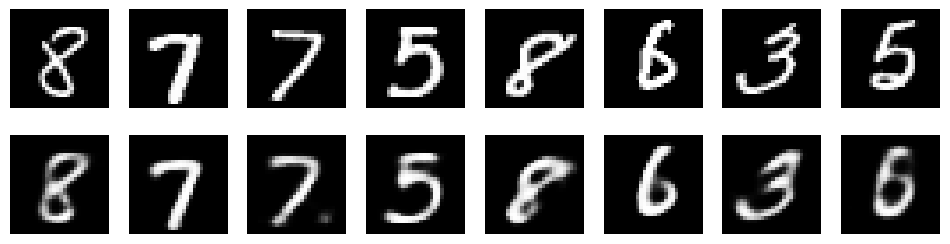

In [42]:
model.eval()

with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.view(x.size(0), -1).to(device)

    x_recon, _, _ = model(x)


n = 8

plt.figure(figsize=(12, 3))

for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(x[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_recon[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")

plt.show()

In [44]:
# now this vae will work as a better generative model than autoencoder for a random unseen image to mnist (random vectors)